# RDFIA: Practical work 2-a
## Transfer Learning through feature extraction from a CNN
### Sorbonne Université 2024
### [Course link](https://rdfia.github.io/)
### GRUSS Carlos, RCHAKI Oussama

### Imports

In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim


from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

import tqdm

### Part 1: VGG16 Architecture

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
# Check if the file is already downloaded
if not os.path.isfile('imagenet_classes.pkl'):
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
if not os.path.isfile('cat.jpg'):
    !wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg

if not os.path.isfile('dog.jpg'):
    !wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

Egyptian cat


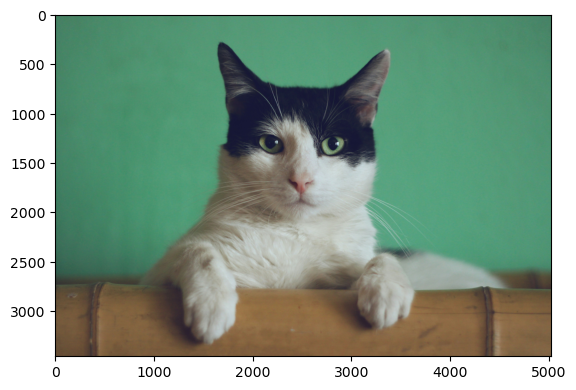

In [3]:
nameim = "cat"+".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))

# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])

# Expand mu & sigma to match image size
mu = mu.view(3,1,1)
sigma = sigma.view(3,1,1)

# compute the normalized image with mean ImageNet image
img = torch.tensor(img)  # Ensure `img` is a PyTorch tensor
img = (img-mu)/sigma

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(weights='IMAGENET1K_V1')
vgg16.eval() 

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img)

with torch.no_grad():   # Disable gradient computation
    y = vgg16(x)

y = y.numpy() # transformation en array numpy
predicted_class = np.argmax(y, axis=1)[0]

# Get prediction label
predicted_label = imagenet_classes[predicted_class]
print(predicted_label)

# Get prediction (i.e., ImageNet class label)

### Part 2: Transfer Learning with VGG16 on 15 Scene

In [4]:
# Uncommment if on Google Colab:
#!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
#!unzip 15ScenesData.zip

# If not on Google Colab:
if not os.path.exists("15ScenesData.zip"):
    print("Downloading 2-ab.zip")
    !wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
    # unzip 
    !tar -xf 15ScenesData.zip

In [5]:
# Google Colab:
#ls 15SceneData/test/bedroom/

# If not on Google Colab:
os.listdir("15SceneData/test/bedroom/")

['image_0128.jpg',
 'image_0077.jpg',
 'image_0182.jpg',
 'image_0153.jpg',
 'image_0121.jpg',
 'image_0037.jpg',
 'image_0113.jpg',
 'image_0114.jpg',
 'image_0203.jpg',
 'image_0030.jpg',
 'image_0168.jpg',
 'image_0093.jpg',
 'image_0042.jpg',
 'image_0166.jpg',
 'image_0039.jpg',
 'image_0161.jpg',
 'image_0170.jpg',
 'image_0054.jpg',
 'image_0053.jpg',
 'image_0082.jpg',
 'image_0021.jpg',
 'image_0026.jpg',
 'image_0215.jpg',
 'image_0013.jpg',
 'image_0130.jpg',
 'image_0068.jpg',
 'image_0014.jpg',
 'image_0066.jpg',
 'image_0142.jpg',
 'image_0160.jpg',
 'image_0095.jpg',
 'image_0092.jpg',
 'image_0043.jpg',
 'image_0115.jpg',
 'image_0202.jpg',
 'image_0112.jpg',
 'image_0205.jpg',
 'image_0003.jpg',
 'image_0120.jpg',
 'image_0004.jpg',
 'image_0152.jpg',
 'image_0071.jpg',
 'image_0144.jpg',
 'image_0195.jpg',
 'image_0138.jpg',
 'image_0060.jpg',
 'image_0067.jpg',
 'image_0192.jpg',
 'image_0131.jpg',
 'image_0069.jpg',
 'image_0103.jpg',
 'image_0104.jpg',
 'image_0020

In [6]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [7]:
PRINT_INTERVAL = 50
CUDA = torch.cuda.is_available()
DEVICE = "cuda:2" if CUDA else "cpu"

mu = [0.485, 0.456, 0.406]  # Mean for normalization (ImageNet)
sigma = [0.229, 0.224, 0.225]  # Std for normalization (ImageNet)

def get_dataset(batch_size, path):
    # Function to expand grayscale images to 3 channels
    def duplicateChannel(img):
        img = img.convert('L')  # Convert to grayscale
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])  # Stack to RGB
        img = Image.fromarray(np_img, 'RGB')
        return img
    
    # Add pre-processing
    transform_pipeline = transforms.Compose([
        transforms.Lambda(duplicateChannel),  # Expand grayscale to RGB
        transforms.Resize((224, 224), interpolation=Image.BILINEAR),  # Resize
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=mu, std=sigma)  # Normalize
    ])

    train_dataset = datasets.ImageFolder(path + '/train', transform=transform_pipeline)
    val_dataset = datasets.ImageFolder(path + '/test', transform=transform_pipeline)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [8]:
def extract_features(data, model):
    #####################
    ## Initialization  ##
    #####################
    # Initialize feature and label storage
    X = []
    y = []

    ########################
    ## Feature Extraction ##
    ########################
    for i, (input, target) in enumerate(data):
        # Print batch progress
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))

        # Move input to GPU if CUDA is enabled
        if CUDA:
            input = input.cuda(device=DEVICE)

        # Extract features
        with torch.no_grad():  # Disable gradients for efficiency
            x = model(input)

        # Detach from computation graph and move to CPU if needed
        x = x.detach().cpu().numpy()
        target = target.cpu().numpy()

        # Append the features and labels
        X.append(x)
        y.append(target)

    # Concatenate all batches into single arrays and convert to tensor
    X = torch.tensor(np.concatenate(X, axis=0))  # X as a PyTorch tensor
    y = torch.tensor(np.concatenate(y, axis=0))  # y as a PyTorch tensor

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(weights='IMAGENET1K_V1')

    print('Instanciation de VGG16relu7')
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7()
    model.eval()
    
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda(device=DEVICE)

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)
    
    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    svm = LinearSVC(C=1.0, max_iter=10000).fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_hat)
    print('Accuracy = %f' % accuracy)
    return svm

In [9]:
svm = main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.885762


Length of the dataset:  2985


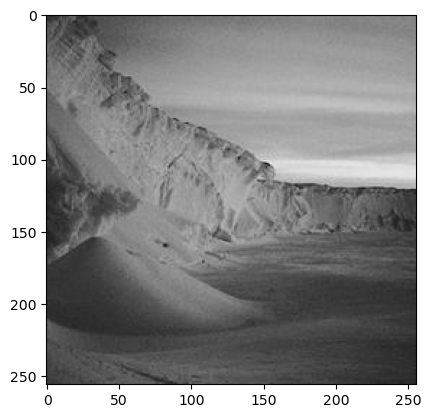

Label:  mountain ( 8 )
Classes:  ['bedroom', 'coast', 'forest', 'highway', 'industrial', 'insidecity', 'kitchen', 'livingroom', 'mountain', 'office', 'opencountry', 'store', 'street', 'suburb', 'tallbuilding']


In [10]:
path = "15SceneData"
val_dataset = datasets.ImageFolder(path + '/test')
print("Length of the dataset: ", len(val_dataset))
img, label = val_dataset[1623]
plt.imshow(img)
plt.show()
print("Label: ", val_dataset.classes[label], "(", label, ")")

# Chemin vers le dataset
path = "15SceneData/train"

# Charger le dataset avec ImageFolder
dataset = datasets.ImageFolder(root=path)

# Extraire les noms des classes
scene_classes = dataset.classes
print("Classes: ", scene_classes)

In [11]:
path = "15SceneData"
train, test = get_dataset(8, path)
model = VGG16relu7()
X_test, y_test = extract_features(test, model)
y = svm.predict(X_test[1623].reshape(1, -1))

Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374


In [12]:
print(y)

[8]


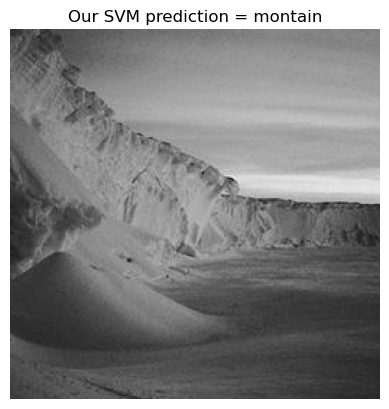

In [13]:
plt.imshow(img)
plt.title("Our SVM prediction = montain")
plt.axis('off')
plt.show()

### Going further

#### Changing the layer at which the features are extracted and experimenting with different C values for SVM

In [14]:
def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(weights='IMAGENET1K_V1')

    print('Instanciation de VGG16relu7')
    model = VGG16relu7()
    model.eval()

    if CUDA: # si on fait du GPU, passage en CUDA
        #cudnn.benchmark = True
        model = model.cuda(device=DEVICE)

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    
    # Normaliser avec L2
    # X_train = normalize(X_train, norm='l2', axis=1)
    # X_test = normalize(X_test, norm='l2', axis=1)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    svm = LinearSVC(C=1e2, max_iter=10000).fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_hat)
    print('Accuracy = %f' % accuracy)
    return svm

svm = main("15SceneData", 8)

Instanciation de VGG16


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.885762


In [15]:
class VGG16relu6(nn.Module):
  def __init__(self):
    super(VGG16relu6, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-4])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x
  
def main(path="15SceneData", batch_size=8):
  print('Instanciation de VGG16')
  vgg16 = models.vgg16(weights='IMAGENET1K_V1')

  print('Instanciation de VGG16relu6')
  model = VGG16relu6()
  model.eval()
  
  if CUDA: # si on fait du GPU, passage en CUDA
      cudnn.benchmark = True
      model = model.cuda(device=DEVICE)

  # On récupère les données
  print('Récupération des données')
  train, test = get_dataset(batch_size, path)
  
  # Extraction des features
  print('Feature extraction')
  X_train, y_train = extract_features(train, model)
  X_test, y_test = extract_features(test, model)

  # Normaliser avec L2
  # X_train = normalize(X_train, norm='l2', axis=1)
  # X_test = normalize(X_test, norm='l2', axis=1)

  # Apprentissage et évaluation des SVM à faire
  print('Apprentissage des SVM')
  accuracy = 0
  svm = LinearSVC(C=1e2, max_iter=10000).fit(X_train, y_train)
  y_hat = svm.predict(X_test)
  accuracy = accuracy_score(y_test, y_hat)

  print('Accuracy = %f' % accuracy)
  return svm

svm = main("15SceneData", 8)

Instanciation de VGG16


Instanciation de VGG16relu6
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.901508


In [16]:
class VGG16relu8(nn.Module):
  def __init__(self):
    super(VGG16relu8, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential(*list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children()))
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x
  
def main(path="15SceneData", batch_size=8):
  print('Instanciation de VGG16')
  vgg16 = models.vgg16(weights='IMAGENET1K_V1')

  print('Instanciation de VGG16relu8')
  model = VGG16relu8()

  model.eval()
  
  if CUDA: # si on fait du GPU, passage en CUDA
      cudnn.benchmark = True
      model = model.cuda(device=DEVICE)

  # On récupère les données
  print('Récupération des données')
  train, test = get_dataset(batch_size, path)
  
  # Extraction des features
  print('Feature extraction')
  X_train, y_train = extract_features(train, model)
  X_test, y_test = extract_features(test, model)

  # Normaliser avec L2
  # X_train = normalize(X_train, norm='l2', axis=1)
  # X_test = normalize(X_test, norm='l2', axis=1)

  print('Apprentissage des SVM')
  accuracy = 0
  svm = LinearSVC(C=1e2, max_iter=10000).fit(X_train, y_train)
  y_hat = svm.predict(X_test)
  accuracy = accuracy_score(y_test, y_hat)

  print('Accuracy = %f' % accuracy)
  return svm

svm = main("15SceneData", 8)

Instanciation de VGG16


Instanciation de VGG16relu8
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 0.851591


#### Other feature extractors

In [17]:
# Loding pre-trained VGG
vgg11 = torchvision.models.vgg11(weights='IMAGENET1K_V1')
vgg11.eval() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [18]:
class VGG11beforelast(nn.Module):
  def __init__(self):
    super(VGG11beforelast, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg11.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg11.classifier.children())[:-2])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [19]:
def main(path="15SceneData", batch_size=8):
    model = VGG11beforelast()

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda(device=DEVICE)

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)    

    # Normaliser avec L2
    X_train = normalize(X_train, norm='l2', axis=1)
    X_test = normalize(X_test, norm='l2', axis=1)

    # Apprentissage et évaluation des SVM 
    print('Apprentissage des SVM')
    accuracy = 0
    svm = LinearSVC(C=1.0).fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_hat)

    print(f"Accuracy = {round(accuracy*100,2)} %")

In [20]:
main("15SceneData", 8)

Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 89.28 %


In [21]:
# Charger le modèle ResNet pré-entraîné
resnet = models.resnet152(weights='DEFAULT')

In [22]:
class Resnetbeforelast(nn.Module):
  def __init__(self):
    super(Resnetbeforelast, self).__init__()
    # Copy the entire convolutional part
    self.features = torch.nn.Sequential(*list(resnet.children())[:-1])
  def forward(self, x):
    x = self.features(x)
    return x

In [23]:
def main(path="15SceneData", batch_size=8):
    model = Resnetbeforelast()

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda(device=DEVICE)

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    # Reshape the features to 2D
    X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (batch_size, num_features)
    X_test = X_test.reshape(X_test.shape[0], -1)  # Flatten to (batch_size, num_features)

    # Normaliser avec L2
    X_train = normalize(X_train, norm='l2', axis=1)
    X_test = normalize(X_test, norm='l2', axis=1)

    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    accuracy = 0
    svm = LinearSVC(C=1.0).fit(X_train, y_train)
    y_hat = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_hat)

    print(f"Accuracy = {round(accuracy*100,2)} %")

In [24]:
main("15SceneData", 8)

Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy = 93.67 %


#### Without SVM

In [25]:
list(vgg16.classifier.children())

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [26]:
class VGG16_Scene15(nn.Module):
    def __init__(self, vgg16):
        super(VGG16_Scene15, self).__init__()
        # Use the features from vgg16
        self.features = vgg16.features
        # Modify the classifier to work with 15 classes
        self.classifier = nn.Sequential(
            *list(vgg16.classifier.children()),
            nn.ReLU(inplace=True), 
            nn.Linear(1000, 15),                      
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(weights='IMAGENET1K_V1')

    print('Instanciation de VGG16_Scene15')
    model = VGG16_Scene15(vgg16)

    # Optionally, freeze the feature extractor parameters
    for param in model.features.parameters():
        param.requires_grad = False

    model.to(DEVICE)

    # Load your dataset
    print('Récupération des données')
    train_loader, test_loader = get_dataset(batch_size, path)  # Ensure this function is defined

    print('Training extended model with gradient descent')

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    # Training loop
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (input, target) in enumerate(train_loader):
            input = input.to(DEVICE)
            target = target.to(DEVICE)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if (i + 1) % PRINT_INTERVAL == 0:
                print('[Epoch %d, Batch %d] loss: %.3f' % (epoch + 1, i + 1, running_loss / PRINT_INTERVAL))
                running_loss = 0.0

    # Evaluation loop
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(DEVICE)
            target = target.to(DEVICE)

            output = model(input)
            _, predicted = torch.max(output, 1)
            total_correct += (predicted == target).sum().item()
            total_samples += target.size(0)

    accuracy = total_correct / total_samples
    print('Accuracy = %f' % accuracy)
    return model

model = main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16_Scene15
Récupération des données
Training extended model with gradient descent
[Epoch 1, Batch 50] loss: 2.655
[Epoch 1, Batch 100] loss: 1.633
[Epoch 1, Batch 150] loss: 1.745
[Epoch 2, Batch 50] loss: 0.693
[Epoch 2, Batch 100] loss: 0.903
[Epoch 2, Batch 150] loss: 0.889
[Epoch 3, Batch 50] loss: 0.855
[Epoch 3, Batch 100] loss: 0.616
[Epoch 3, Batch 150] loss: 0.536
[Epoch 4, Batch 50] loss: 0.550
[Epoch 4, Batch 100] loss: 1.019
[Epoch 4, Batch 150] loss: 0.729
[Epoch 5, Batch 50] loss: 0.364
[Epoch 5, Batch 100] loss: 0.523
[Epoch 5, Batch 150] loss: 0.509
[Epoch 6, Batch 50] loss: 0.947
[Epoch 6, Batch 100] loss: 0.582
[Epoch 6, Batch 150] loss: 0.734
[Epoch 7, Batch 50] loss: 0.553
[Epoch 7, Batch 100] loss: 0.575
[Epoch 7, Batch 150] loss: 0.968
[Epoch 8, Batch 50] loss: 0.874
[Epoch 8, Batch 100] loss: 1.461
[Epoch 8, Batch 150] loss: 1.052
[Epoch 9, Batch 50] loss: 0.648
[Epoch 9, Batch 100] loss: 0.526
[Epoch 9, Batch 150] loss:

#### Fine tuning

In [ ]:
# Appliquer des transformations (normalisation, redimensionnement, etc.)
path = "15SceneData"

batch_size = 32

train_loader, val_loader = get_dataset(batch_size, path)

# Charger le modèle ResNet pré-entraîné
model = models.resnet50(pretrained=True)

# Freeze all layers: disable gradient tracking
for p in model.parameters():
    p.requires_grad = False
# "Thaw" last layer (or whatever is relevant for you)
for p in model.layer2.parameters():
    p.requires_grad = True
for p in model.layer3.parameters():
    p.requires_grad = True
for p in model.layer4.parameters():
    p.requires_grad = True

# Replace fully-connected part by some other classifier, e.g.

cnn_features = 2048
num_classes = 15

model.fc =  nn.Sequential(
    nn.Linear(cnn_features, 100, bias=True),
    nn.ReLU(),
    nn.Linear(100, num_classes, bias=True),
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model=model.to(device)

def loss_accuracy(loss, Yhat, Y):
    L = loss(Yhat, Y)
    acc = (torch.sum(torch.argmax(Yhat, dim=1) == Y) / Y.size(0)) * 100
    return L, acc

n_iter=30

loss = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Planificateur StepLR : Réduction du LR tous les 10 epochs par un facteur 0.1
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
batch_size=32

# Evaluation in mini-batches because my RAM is insufficient to calculate the loss all at once for the entire test dataset
def evaluate_model(model, test_loader, loss_fn, device):
    model.eval()  # Mode évaluation
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Pas de calcul des gradients
        for X_batch, Y_batch in test_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)  # Déplacer sur GPU
            Yhat = model(X_batch)  # Prédictions
            loss = loss_fn(Yhat, Y_batch)  # Calcul de la perte
            total_loss += loss.item() * X_batch.size(0)  # Ajouter perte pondérée par la taille du batch
            total_correct += (torch.argmax(Yhat, dim=1) == Y_batch).sum().item()  # Compter les bons résultats
            total_samples += X_batch.size(0)  # Total des échantillons
    print(total_samples, total_loss)
    avg_loss = total_loss / total_samples  # Moyenne des pertes
    avg_accuracy = (total_correct / total_samples) * 100  # Précision en pourcentage
    return avg_loss, avg_accuracy

# epoch
for iteration in tqdm(range(n_iter), desc="Epochs", unit="epoch"):
    
        for X_batch, Y_batch in tqdm(train_loader, desc="Batches", unit="batch", leave=False):
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) 
                optimizer.zero_grad()
                Yhat = model(X_batch)  # Prédictions pour le batch actuel
                L, acc = loss_accuracy(loss, Yhat, Y_batch)  # Calcul de la perte et de la précision
                L.backward()
                optimizer.step()
        scheduler.step()
    
        Ltest, acctest = evaluate_model(model, val_loader, loss, device)
    
        title = "Iter {}:, acc test {:.2f}% ({:.2f})".format(iteration, acctest, Ltest)
    
        print(title)